# Variational Autoencoder (VAE) Tutorial with MNIST

This notebook demonstrates the implementation of a VAE on the MNIST dataset.

---

## 1. Setup and Imports

We first import necessary libraries and check for GPU availability.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## 2. Load Dataset (MNIST)

We load MNIST dataset and create training and validation splits.


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_data, val_data = random_split(dataset, [50000, 10000])
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

## 3. Define the VAE Model

The encoder outputs the mean and log variance vectors.  
The reparameterization trick allows backpropagation through the sampling step.  
The decoder reconstructs the input image from the sampled latent vector.


In [4]:
class VAE(nn.Module):
    def __init__(self, latent_dim=64):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder layers
        self.encoder_fc1 = nn.Linear(28*28, 128)
        self.encoder_fc2_mu = nn.Linear(128, latent_dim)       # Mean
        self.encoder_fc2_logvar = nn.Linear(128, latent_dim)   # Log variance
        
        # Decoder layers
        self.decoder_fc1 = nn.Linear(latent_dim, 128)
        self.decoder_fc2 = nn.Linear(128, 28*28)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def encode(self, x):
        h1 = self.relu(self.encoder_fc1(x))
        mu = self.encoder_fc2_mu(h1)
        logvar = self.encoder_fc2_logvar(h1)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)       
        eps = torch.randn_like(std)          
        return mu + eps * std                 
    
    def decode(self, z):
        h3 = self.relu(self.decoder_fc1(z))
        out = self.sigmoid(self.decoder_fc2(h3))
        return out
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        out = self.decode(z)
        return out, mu, logvar


## 4. Define the Loss Function

The loss consists of reconstruction loss (binary cross entropy) and KL divergence.

In [5]:
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


## 5. Instantiate the Model and Optimizer

In [6]:
latent_dim = 64
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)


## 6. Training Loop

In [7]:
epochs = 5
model.train()
for epoch in range(epochs):
    train_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        recon_images, mu, logvar = model(images)
        loss = vae_loss(recon_images, images, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    avg_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")


Epoch 1, Average Loss: 182.3138
Epoch 2, Average Loss: 138.7585
Epoch 3, Average Loss: 126.9666
Epoch 4, Average Loss: 120.4095
Epoch 5, Average Loss: 116.8417


## 7. Visualize Reconstructions

Compare original and reconstructed images from the validation set.

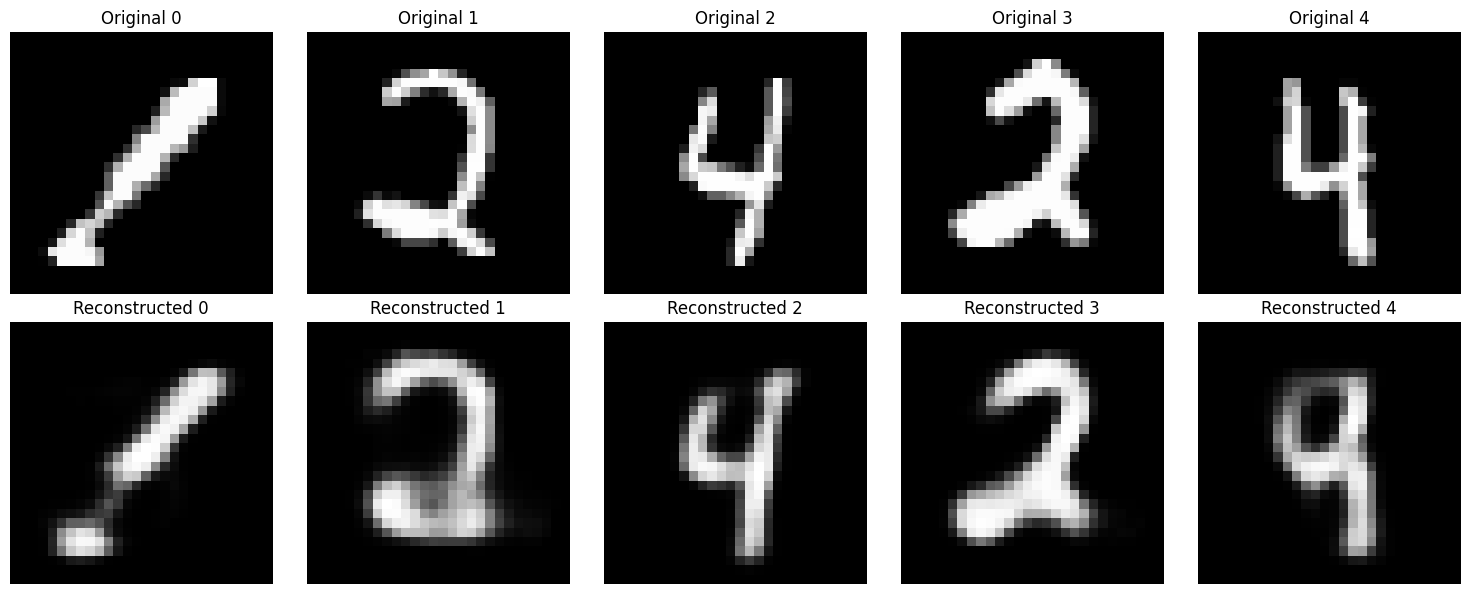

In [8]:
def show_reconstruction(num_images=5):
    model.eval()
    with torch.no_grad():
        for images, _ in val_loader:
            images = images.to(device)
            recon_images, _, _ = model(images)
            break

    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 3, 6))
    for i in range(num_images):
        axes[0, i].imshow(images[i].cpu().squeeze(), cmap='gray')
        axes[0, i].set_title(f"Original {i}")
        axes[0, i].axis('off')

        axes[1, i].imshow(recon_images[i].cpu().view(28, 28), cmap='gray')
        axes[1, i].set_title(f"Reconstructed {i}")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

show_reconstruction(5)


## 8. Sampling New Images from the Latent Space

We sample latent vectors from a standard normal distribution and decode them into new images.

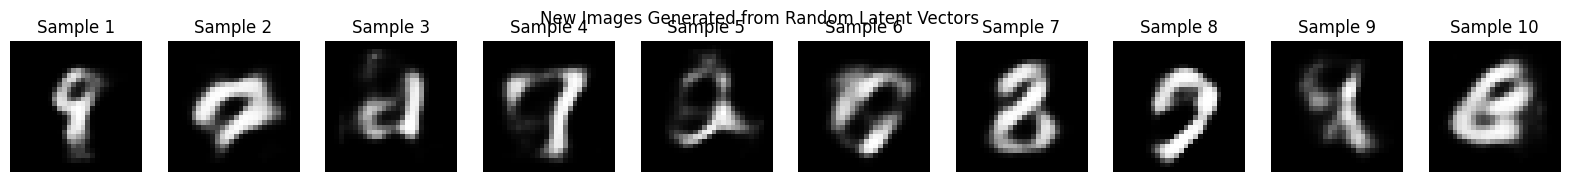

In [10]:
# Number of random samples to generate
num_samples = 10

# Sample random latent vectors from standard normal distribution
random_latents = torch.randn(num_samples, latent_dim).to(device)

# Decode to generate new images
model.eval()
with torch.no_grad():
    generated_images = model.decode(random_latents)  # shape [num_samples, 28*28]

# Visualize generated images
fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
for i in range(num_samples):
    axes[i].imshow(generated_images[i].cpu().view(28, 28), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'Sample {i+1}')

plt.suptitle("New Images Generated from Random Latent Vectors")
plt.show()


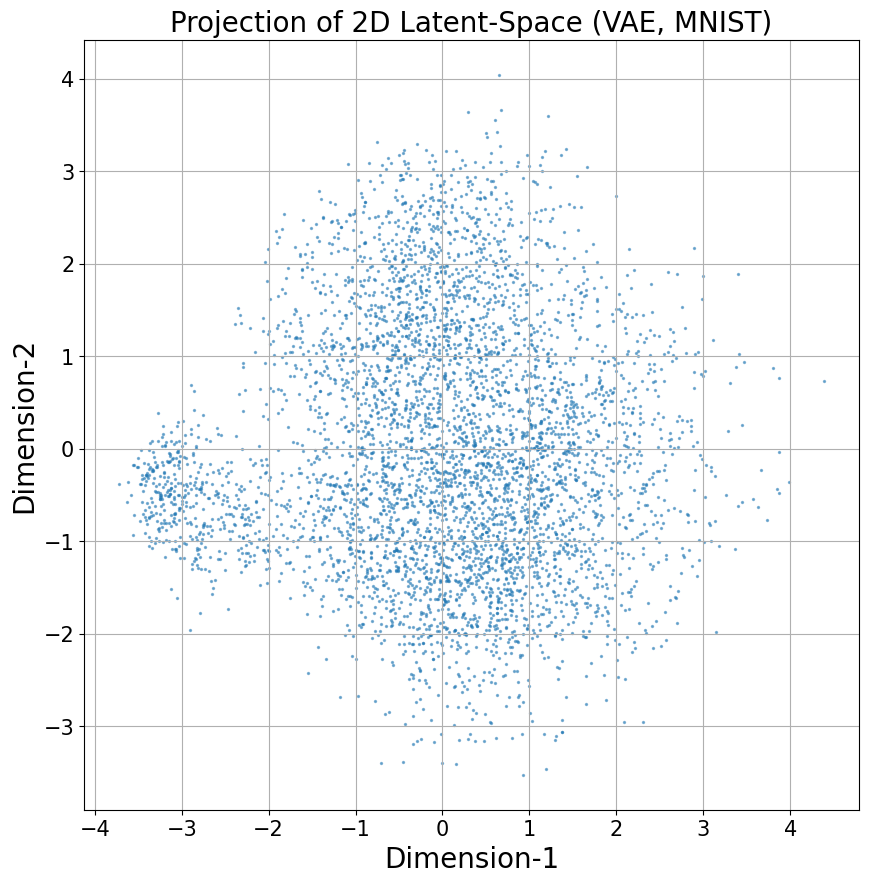

In [15]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

imgs_visualize = 5000
figsize = 10

# Stack validation images and labels
val_images = torch.stack([item[0] for item in val_data])  # shape [10000, 1, 28, 28]

# Random sample 5K images
indices = np.random.choice(len(val_images), imgs_visualize, replace=False)
images_sample = val_images[indices].to(device)

model.eval()
with torch.no_grad():
    # Get the mean vector mu from the encoder as latent representation
    x = images_sample.view(imgs_visualize, -1)
    mu, logvar = model.encode(x)
    latent_vectors = mu  # Use mu for visualization

# PCA reduction to 2D
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_vectors.cpu().numpy())

# Plot without color coding
plt.figure(figsize=(figsize, figsize))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], alpha=0.5, s=2)
plt.xlabel("Dimension-1", size=20)
plt.ylabel("Dimension-2", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title("Projection of 2D Latent-Space (VAE, MNIST)", size=20)
plt.grid(True)
plt.show()
